In [9]:
clear all
close all
clc

%% params
    depb = round(200 / 16); % 200 meters below surface divided by bin size of 16m
    timeBuffer = 120; % time in minutes before and after which a ctd cast is matched to underway data for pca plots
    
%% Load Data
% load underway data
    fidunderwayADCPnc = 'rb1304_os75nb.nc';
    % fidunderwayADCPnc = 'rb1307_os75bb.nc';
    uADCPinfo = ncinfo(fidunderwayADCPnc);
    % startLoc = [1 1]; % Start location along each coordinate
    % count  = [Inf Inf]; % Read until the end of each dimension

    unu = ncread(fidunderwayADCPnc,'u');
    unv = ncread(fidunderwayADCPnc,'v');
    unlon = ncread(fidunderwayADCPnc,'lon');
    unlat = ncread(fidunderwayADCPnc,'lat');
    undep = ncread(fidunderwayADCPnc,'depth');

    % convert time to datenum
    untimeJD = ncread(fidunderwayADCPnc,'time');
    untimeDays = days(untimeJD);
    untimePivot = datetime(datestr('2013-01-01 00:00:00'));
    unTime = untimeDays + untimePivot;

    % NaN out of range data
    deleteV=unu>20; unu(deleteV)=NaN;
    deleteU=unv>20; unv(deleteU)=NaN;

    % assign NaNs to mean value for u an v
    unu2 = unu(1:depb,:);       unv2 = unv(1:depb,:); % only look at top 400 meters ie. first 25 bins
    qq=find(isnan(unu2)==1);    rr=find(isnan(unv2)==1);
    meanUUN2=nanmean(unu2(:));  meanVUN2=nanmean(unv2(:));
    unu2(qq)=meanUUN2;          unv2(rr)=meanVUN2;

% load CTD directory
    ncfileCTD_fo = '/Users/noahwalcutt/Documents/MatLab/orientation/A16N_2013/33RO20130803_nc_ctd/';
    % ncfileCTD = '/Users/noahwalcutt/Documents/MatLab/orientation/A16N_2013/33RO20130803_nc_ctd/33RO20130803_00001_00001_ctd.nc';

    % list all nc ctd files remove . and .. files
    ctdNCfiles = dir(ncfileCTD_fo);
    ctdNCfiles=ctdNCfiles(~ismember({ctdNCfiles.name},{'.','..'}));
    for i = 1:length(ctdNCfiles)
    ctdAllNCFiles{i,1} = [ncfileCTD_fo,ctdNCfiles(i).name];
    end
    
    %     for ctdfile = 1:length(ctdAllNCFiles)%50
%         ctdTime = ncread(ctdAllNCFiles{ctdfile},'time');
%         ctdTimeMinutes = minutes(ctdTime);
%         ctdTimeMinutesSave(ctdfile) = minutes(ctdTime);
%         pivotyear = datetime(datestr('1980-01-01 00:00:00'));
%         ctdTime = ctdTimeMinutes + pivotyear;
%         ctdTimeSave(ctdfile) = ctdTimeMinutes + pivotyear;
%     end
    
    load ctdTimeSave
    
% load ladcp data
    ladcpInfoNC = '/Users/noahwalcutt/Documents/MatLab/orientation/A16N_2013/A16N_2013.nc';
    ladcpinfo = ncinfo(ladcpInfoNC);
    ladcpTime = ncread(ladcpInfoNC,'jul');
    ladcpU = ncread(ladcpInfoNC,'u');
    ladcpV = ncread(ladcpInfoNC,'v');
    ladcpZ = ncread(ladcpInfoNC,'z');
    % time adjust
    ladcpTimedays = days(ladcpTime);
    ladcppivotyear = datetime(datestr('2000-01-01 00:00:00'));
    ladcpTimeAll = ladcpTimedays + ladcppivotyear;
    
% create a midpoint duration vector
    ctdTimeMidpointsMin = diff(ctdTimeMinutesSave)./2;%+ctdTimeSave(1:end-1);
    ctdTimeMidpointsMin(ctdTimeMidpointsMin>minutes(800))=median(ctdTimeMidpointsMin);
    a1=ctdTimeMidpointsMin(1);a2=ctdTimeMidpointsMin;
    ctdTimeMidpointsMin = [a1,a2]; % make the first midpoint equal to the first value
    ctdTimeMidpointsMin(end+1)=median(ctdTimeMidpointsMin); % make the last midpoint equal to the median
    
%% Loop through all the ctd/uadcp/ladcp data
    for ctdfile = 3%:10%:20%5% 1:length(ctdAllNCFiles)%50
        
    % ncid = netcdf.open(ncfile);
%% load the ctd data
    finfo = ncinfo(ctdAllNCFiles{ctdfile});
        try
        ctdFl = ncread(ctdAllNCFiles{ctdfile},'FLUORM');
        catch
        ctdFl = NaN;
        end
% load ctd data
    ctdTime = ncread(ctdAllNCFiles{ctdfile},'time');
    ctdStation = ncread(ctdAllNCFiles{ctdfile},'station');
    ctdCast = ncread(ctdAllNCFiles{ctdfile},'cast');
    ctdCT = ncread(ctdAllNCFiles{ctdfile},'temperature');
    ctdSA = ncread(ctdAllNCFiles{ctdfile},'salinity');
    ctdLat = ncread(ctdAllNCFiles{ctdfile},'latitude');
    ctdPrZ = ncread(ctdAllNCFiles{ctdfile},'pressure'); % 1 db = 1m sw
    
    ctd_Density_sigma1_CT_exact = gsw_sigma1_CT_exact(ctdSA,ctdCT) + 1000; % kg/m3
    [ctdN2, ctdN2p_mid] = gsw_Nsquared(ctdSA,ctdCT,ctdPrZ,ctdLat);
    
    % ctdTimeWoceDate = ncread(ctdAllNCFiles{ctdfile},'woce_date');
    % ctdTimeWocetime = ncread(ctdAllNCFiles{ctdfile},'woce_time');
    ctdTimeMinutes = minutes(ctdTime);
    pivotyear = datetime(datestr('1980-01-01 00:00:00'));
    ctdTime = ctdTimeMinutes + pivotyear;
    
% load ladcp data
    ladcpInfoNC = '/Users/noahwalcutt/Documents/MatLab/orientation/A16N_2013/A16N_2013.nc';
    ladcpinfo = ncinfo(ladcpInfoNC);
    ladcpTime = ncread(ladcpInfoNC,'jul');
    ladcpU = ncread(ladcpInfoNC,'u');
    ladcpV = ncread(ladcpInfoNC,'v');
    ladcpZ = ncread(ladcpInfoNC,'z');
    % time adjust
    ladcpTimedays = days(ladcpTime);
    ladcppivotyear = datetime(datestr('2000-01-01 00:00:00'));
    ladcpTimeAll = ladcpTimedays + ladcppivotyear;
    
% match the underway and the CTD times to a certain buffer on either side
%     matchUNlower = ctdTime-minutes(timeBuffer);
%     matchUNupper = ctdTime+minutes(timeBuffer);
    matchUNlower = ctdTime-ctdTimeMidpointsMin(ctdfile);
    matchUNupper = ctdTime+ctdTimeMidpointsMin(ctdfile+1);
    matchUNctd = isbetween(unTime,matchUNlower,matchUNupper);
    matchUNBufferidx = find(matchUNctd==1);
    matchUNctdTimes = unTime(matchUNBufferidx);
%     matchUNctdTimes = unTime(matchUNctd);
    matchUNctdTimesSTR = cellstr(datestr(matchUNctdTimes));


% match the CTD and the LADCP times to 10 minutes, because there may not be ladcp data for every cast
    matchCTDlower = ctdTime-minutes(5);
    matchCTDupper = ctdTime+minutes(5);
    matchCTDladcp = isbetween(ladcpTimeAll,matchCTDlower,matchCTDupper);
    matchCTDladcpBufferidx = find(matchCTDladcp==1);
    matchCTDladcpTimes = ladcpTimeAll(matchCTDladcpBufferidx);
    % grab the right data for the plot
    ladcpUcast = ladcpU(:,matchCTDladcpBufferidx);
    ladcpVcast = ladcpV(:,matchCTDladcpBufferidx);
    
% compute the new bin centers for the z data
    meanDep = mean(diff(undep(:,1))); % undepNewBin(1:13,1)
    undepNewBin = undep(1:end-1,:)-meanDep; % interpolate shift bins down by half, remove one bin
    yaxisDepthCenter = undepNewBin(1:12,1);
    
% pca - do the pca for first two components
    unuP = princompNoah(unu2(:,matchUNBufferidx),2);
    unvP = princompNoah(unv2(:,matchUNBufferidx),2);
    % smooth the eigenvalues from PCA1
    unuPCA1 = smooth(unuP.Y(:,1));
    unvPCA1 = smooth(unvP.Y(:,1));
    % compute vertical derivative from first eigenvalue, and then square
    shPCA1u = (diff(unuPCA1) ./ meanDep);%.^2; % (du/dz)^2
    shPCA1v = (diff(unvPCA1) ./ meanDep);%.^2; % (dv/dz)^2
    unuPCA = shPCA1u * unuP.A(1,1:end-1);
    unvPCA = shPCA1v * unvP.A(1,1:end-1);
    
    unuPCA1n = unuP.Y(:,1) * unuP.A(1,:);
    unvPCA1n = unvP.Y(:,1) * unvP.A(1,:);
    
% compute the diff along the vertical axis for u an v
    diffU = diff(unuPCA,[],1)./16; % ;%./ diff(undep(:,1)).^2;
    diffV = diff(unvPCA,[],1)./ 16; % diff(undep(:,1)).^2;
    unshear  = diffU.^2 + diffV.^2;
    end



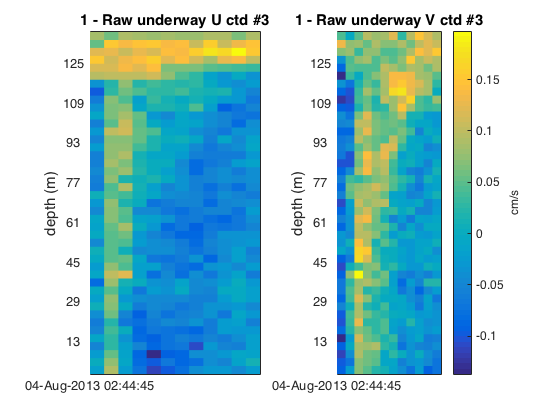

In [10]:
%% 1 - plot for U and V pcolor -- center y-ticks
    figure(1)
        subplot(121)
        pcolor(unu2(:,matchUNBufferidx)') %matchUNctdTimes,undepNewBin(1:13,1),
    % title(['v station ', ctdStation(ctdfile), ' cast ',ctdCast(ctdfile)])
    title(['1 - Raw underway U ctd #', num2str(ctdfile)])
    ylabel('depth (m)')
    shading flat
    %axis ij
%     cb = colorbar;
%     xlabel(cb,'u (cm/s)')
    
    hh = gca;
    matchUNctdTimesSTRmid = floor(length(matchUNctdTimes)/2);
    hh.XTick = [1 matchUNctdTimesSTRmid length(matchUNctdTimes)];
    labfirst = matchUNctdTimesSTR(1);
    labmiddle = matchUNctdTimesSTR(matchUNctdTimesSTRmid);
    lablast = matchUNctdTimesSTR(end);
    hh.XTickLabel = [labfirst,labmiddle,lablast];
    hh.YTickLabel = round(undepNewBin(1:13,1));
    
    subplot(122)
            pcolor(unv2(:,matchUNBufferidx)') %matchUNctdTimes,undepNewBin(1:13,1),
    % title(['v station ', ctdStation(ctdfile), ' cast ',ctdCast(ctdfile)])
    title(['1 - Raw underway V ctd #', num2str(ctdfile)])
    ylabel('depth (m)')
    shading flat
    %axis ij
    cb = colorbar;
    xlabel(cb,'cm/s')
    
    hh = gca;
    matchUNctdTimesSTRmid = floor(length(matchUNctdTimes)/2);
    hh.XTick = [1 matchUNctdTimesSTRmid length(matchUNctdTimes)];
    labfirst = matchUNctdTimesSTR(1);
    labmiddle = matchUNctdTimesSTR(matchUNctdTimesSTRmid);
    lablast = matchUNctdTimesSTR(end);
    hh.XTickLabel = [labfirst,labmiddle,lablast];
    hh.YTickLabel = round(undepNewBin(1:13,1));
    
    hhh=gcf;
    hhh.Position = [1 378 1440 420];
    set(gcf,'color','w')


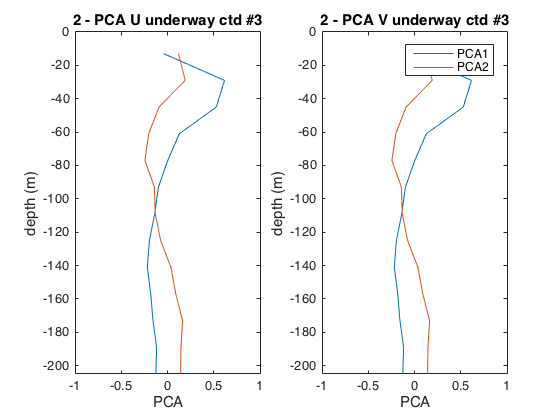

In [3]:
%% 2 - plot eigenvalues
    figure(2)
        subplot(121)
        plot(unuP.Y(:,1),-undepNewBin(1:13,1))
        hold on
        plot(unuP.Y(:,2),-undepNewBin(1:13,1))
        title(['2 - PCA U underway ctd #', num2str(ctdfile)])
        ylabel('depth (m)')
        xlabel('PCA')
        axis([-1 1 -undepNewBin(13,1) 0])
        hold off

        subplot(122)
        a1=plot(unuP.Y(:,1),-undepNewBin(1:13,1));
        hold on
        a2=plot(unuP.Y(:,2),-undepNewBin(1:13,1));
        title(['2 - PCA V underway ctd #', num2str(ctdfile)])
        ylabel('depth (m)')
        xlabel('PCA')
        axis([-1 1 -undepNewBin(13,1) 0])
        l = legend([a1,a2],{'PCA1','PCA2'});
        
        
        hold off        
        hhh=gcf;
        hhh.Position = [1 378 1440 420];
        set(gcf,'color','w')


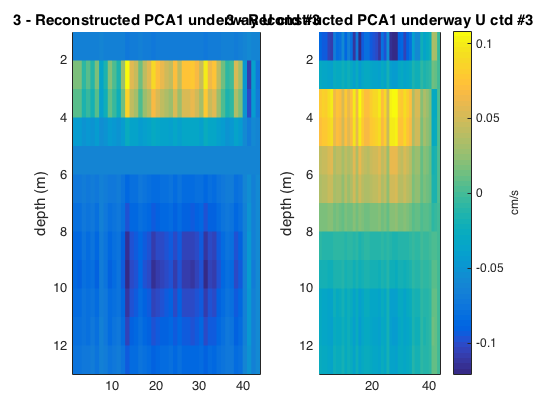

In [11]:
%% 3 - plot reconstructed u and v of first eigenvalue 1 with amplitude 1 (pcolor)
figure(3)
    subplot(121)
    pcolor(unuPCA1n) %matchUNctdTimes,undepNewBin(1:13,1),
    % title(['v station ', ctdStation(ctdfile), ' cast ',ctdCast(ctdfile)])
    title(['3 - Reconstructed PCA1 underway U ctd #', num2str(ctdfile)])
    ylabel('depth (m)')
    shading flat
    axis ij
%     cb = colorbar;
%     xlabel(cb,'u (cm/s)')
    
%     hh = gca;
%     matchUNctdTimesSTRmid = floor(length(matchUNctdTimes)/2);
%     hh.XTick = [1 matchUNctdTimesSTRmid length(matchUNctdTimes)];
%     labfirst = matchUNctdTimesSTR(1);
%     labmiddle = matchUNctdTimesSTR(matchUNctdTimesSTRmid);
%     lablast = matchUNctdTimesSTR(end);
%     hh.XTickLabel = [labfirst,labmiddle,lablast];
%     hh.YTickLabel = round(undepNewBin(1:13,1));
    
    subplot(122)
    pcolor(unvPCA1n) %matchUNctdTimes,undepNewBin(1:13,1),
    % title(['v station ', ctdStation(ctdfile), ' cast ',ctdCast(ctdfile)])
    title(['3 - Reconstructed PCA1 underway U ctd #', num2str(ctdfile)])
    ylabel('depth (m)')
    shading flat
    axis ij
    cb = colorbar;
    xlabel(cb,'cm/s')
    
%     hh = gca;
%     matchUNctdTimesSTRmid = floor(length(matchUNctdTimes)/2);
%     hh.XTick = [1 matchUNctdTimesSTRmid length(matchUNctdTimes)];
%     labfirst = matchUNctdTimesSTR(1);
%     labmiddle = matchUNctdTimesSTR(matchUNctdTimesSTRmid);
%     lablast = matchUNctdTimesSTR(end);
%     hh.XTickLabel = [labfirst,labmiddle,lablast];
%     hh.YTickLabel = round(undepNewBin(1:13,1));
    
    hhh=gcf;
    hhh.Position = [1 378 1440 420];
    set(gcf,'color','w')

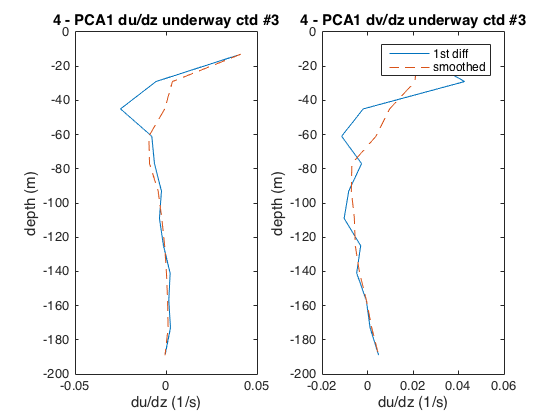

In [5]:
%% 4 - compute first difference of eigenvalue (d_eig / d_z) v. z
duEigdZPCA1 = diff(unuP.Y(:,1),[],1)./16; dvEigdZPCA1 = diff(unvP.Y(:,1),[],1)./16;
duEigdZPCA1smooth = smooth(duEigdZPCA1); dvEigdZPCA1smooth = smooth(dvEigdZPCA1);

    figure(4)
        subplot(121)
        plot(duEigdZPCA1,-yaxisDepthCenter)
        hold on
        plot(duEigdZPCA1smooth,-yaxisDepthCenter,'--')
        title(['4 - PCA1 du/dz underway ctd #', num2str(ctdfile)])
        ylabel('depth (m)')
        xlabel('du/dz (1/s)')
%         axis([-1 1 -undepNewBin(13,1) 0])
        hold off

        subplot(122)
        a1=plot(dvEigdZPCA1,-yaxisDepthCenter);
        hold on
        a2=plot(dvEigdZPCA1smooth,-yaxisDepthCenter,'--');
        title(['4 - PCA1 dv/dz underway ctd #', num2str(ctdfile)])
        ylabel('depth (m)')
        xlabel('du/dz (1/s)')
%         axis([-1 1 -undepNewBin(13,1) 0])
        hold off
        
        l = legend([a1,a2],{'1st diff','smoothed'});
        
        hold off        
        hhh=gcf;
        hhh.Position = [1 378 1440 420];
        set(gcf,'color','w')

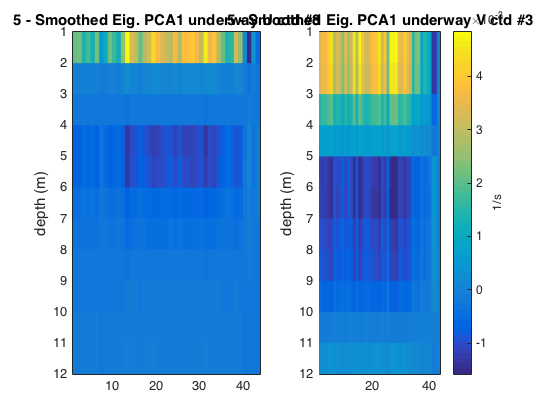

In [6]:
%% 5 - compute du/dz and dv/dz pcolor from smoothed d-eigen(1) / dz * amp (1)
duEigdZPCA1smoothPcolor = duEigdZPCA1smooth * unuP.A(1,:);
dvEigdZPCA1smoothPcolor = dvEigdZPCA1smooth * unvP.A(1,:);

figure(5)
    subplot(121)
    pcolor(duEigdZPCA1smoothPcolor) %matchUNctdTimes,undepNewBin(1:13,1),
    % title(['v station ', ctdStation(ctdfile), ' cast ',ctdCast(ctdfile)])
    title(['5 - Smoothed Eig. PCA1 underway U ctd #', num2str(ctdfile)])
    ylabel('depth (m)')
    shading flat
    axis ij
%     cb = colorbar;
%     xlabel(cb,'u (cm/s)')
    
%     hh = gca;
%     matchUNctdTimesSTRmid = floor(length(matchUNctdTimes)/2);
%     hh.XTick = [1 matchUNctdTimesSTRmid length(matchUNctdTimes)];
%     labfirst = matchUNctdTimesSTR(1);
%     labmiddle = matchUNctdTimesSTR(matchUNctdTimesSTRmid);
%     lablast = matchUNctdTimesSTR(end);
%     hh.XTickLabel = [labfirst,labmiddle,lablast];
%     hh.YTickLabel = round(undepNewBin(1:13,1));
    
    subplot(122)
    pcolor(dvEigdZPCA1smoothPcolor) %matchUNctdTimes,undepNewBin(1:13,1),
    % title(['v station ', ctdStation(ctdfile), ' cast ',ctdCast(ctdfile)])
    title(['5 - Smoothed Eig. PCA1 underway V ctd #', num2str(ctdfile)])
    ylabel('depth (m)')
    shading flat
    axis ij
    cb = colorbar;
    xlabel(cb,'1/s')
    
%     hh = gca;
%     matchUNctdTimesSTRmid = floor(length(matchUNctdTimes)/2);
%     hh.XTick = [1 matchUNctdTimesSTRmid length(matchUNctdTimes)];
%     labfirst = matchUNctdTimesSTR(1);
%     labmiddle = matchUNctdTimesSTR(matchUNctdTimesSTRmid);
%     lablast = matchUNctdTimesSTR(end);
%     hh.XTickLabel = [labfirst,labmiddle,lablast];
%     hh.YTickLabel = round(undepNewBin(1:13,1));
    
    hhh=gcf;
    hhh.Position = [1 378 1440 420];
    set(gcf,'color','w')

